In [148]:
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG19

img_size = (224, 224)

def create_encoder(output_layer='block3_conv1'):
    vgg = VGG19(include_top=False, input_shape=(*img_size, 3))
    output = vgg.get_layer(output_layer).output
    
    model = Model(vgg.input, outputs=[output])
    model.build(img_size)
    return model

def transform(model, array):
    return model.predict(np.array([array]))[0]

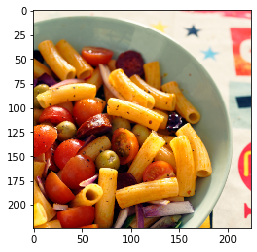

In [149]:
from wct.img import imread
import numpy as np

encoder = create_encoder()
img = imread('images/pasta.png')
img_map = transform(encoder, img)
img_map.shape
imshow(img)

In [150]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, UpSampling2D
from wct.layers import ReflectingConv2D

def create_decoder(input_shape=(56, 56, 256)):
    return Sequential([
        Input(shape=input_shape),
        ReflectingConv2D(128, (3, 3), activation='relu', name='dec_block3_conv1'),
        UpSampling2D(interpolation='nearest', name='dec_block3_upsample'),
        ReflectingConv2D(128, (3, 3), activation='relu', name='dec_block3_conv2'),
        ReflectingConv2D(64, (3, 3), activation='relu', name='dec_block2_conv1'),
        UpSampling2D(interpolation='nearest', name='dec_block2_upsample'),
        ReflectingConv2D(64, (3, 3), activation='relu', name='dec_block1_conv1'),
        ReflectingConv2D(3, 3, activation='sigmoid', name='dec_output')
    ])

In [151]:
decoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_block3_conv1 (Lambda)    (None, 56, 56, 128)       295040    
_________________________________________________________________
dec_block3_upsample (UpSampl (None, 112, 112, 128)     0         
_________________________________________________________________
dec_block3_conv2 (Lambda)    (None, 112, 112, 128)     147584    
_________________________________________________________________
dec_block2_conv1 (Lambda)    (None, 112, 112, 64)      73792     
_________________________________________________________________
dec_block2_upsample (UpSampl (None, 224, 224, 64)      0         
_________________________________________________________________
dec_block1_conv1 (Lambda)    (None, 224, 224, 64)      36928     
_________________________________________________________________
dec_output (Lambda)          (None, 224, 224, 3)      

In [152]:
decoder = create_decoder()
reconstruction = transform(decoder, img_map)
reconstruction.shape

(224, 224, 3)

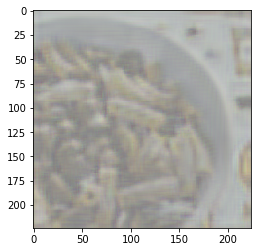

In [153]:
%matplotlib inline
from wct.img import imshow

decoder.load_weights('models/decoder0.h5')
reconstruction = transform(decoder, img_map)
imshow(reconstruction)

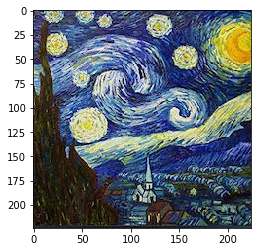

In [154]:
style = imread('styles/vangogh.jpg')
style_map = transform(encoder, style)
imshow(style)

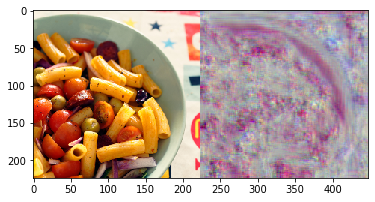

In [155]:
def reshape(array):
    height, width, depth = array.shape
    return array.transpose((2, 0, 1)).reshape(-1, width * height)

def wrap_reshape(function):
    def wrapped(*args):
        args_reshaped = [reshape(arg) for arg in args]
        output = function(*args_reshaped)
        return output.transpose().reshape(args[0].shape)
    return wrapped

@wrap_reshape
def whitening_transform(features):
    features -= features.mean(axis=1, keepdims=True) # center (mean wrt. spatial dimension)
    product = np.dot(features, features.T) / (features.shape[1] - 1) # why divide?
    Ec, wc, _ = np.linalg.svd(product)
    Dc = np.diag(wc)
#     assert((product - Ec.dot(Dc).dot(Ec.T) < 1e-4).all()) # Ec * Dc * Ec^T == features * features^T
    Dc_minus_half = np.linalg.inv(Dc) ** 0.5
    return Ec.dot(Dc_minus_half).dot(Ec.T).dot(features)

def normalize(array):
    return np.interp(array, (array.min(), array.max()), (0.0, 1.0)).astype(np.float32)

img_map_uncor = whitening_transform(img_map)
intermediate = transform(decoder, img_map_uncor)
intermediate = normalize(intermediate)

imshow(np.column_stack([img, intermediate]))

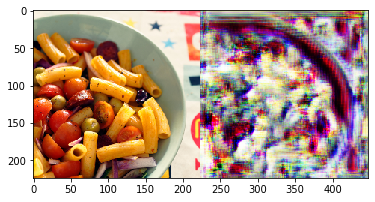

In [156]:
@wrap_reshape
def coloring_transform(style_features, content_features):
    mean = style_features.mean(axis=1, keepdims=True) # center (mean wrt. spatial dimension)
    style_features -= mean
    
    product = np.dot(style_features, style_features.T) / (style_features.shape[1] - 1)
    Es, ws, _ = np.linalg.svd(product)
    Ds = np.diag(ws)
    return Es.dot(Ds).dot(Es.T).dot(content_features) + mean

new_image = coloring_transform(style_map, img_map_uncor)
imshow(np.column_stack([img, transform(decoder, new_image)]))

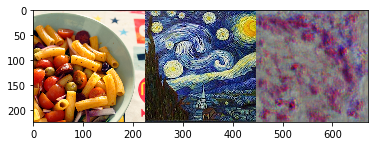

In [157]:
def blend(original, new, alpha=0.1):
    return alpha * new + (1 - alpha) * original

blended = blend(img_map, new_image_viz)
imshow(
    np.column_stack([
        img,
        style,
        transform(decoder, blended)
    ])
)

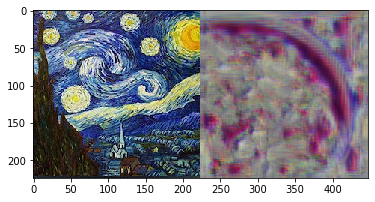

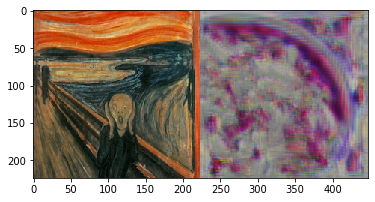

In [162]:
from glob import glob

def wct(style, content):
    style_map = transform(encoder, style)
    content_map = transform(encoder, content)
    whitened = whitening_transform(content_map)
    colored = coloring_transform(style_map, whitened)
    blended = blend(content_map, colored)
    return transform(decoder, blended)

for style_path in glob('styles/*'):
    style = imread(style_path)
    stylized = wct(style, img)
    imshow(np.column_stack([style, stylized]))
    plt.show()